In [1]:
!pip install torchsde

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [3]:
import numpy as np
import torch
import torch.optim.swa_utils as swa_utils
import torchsde
import tqdm

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (5, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
class LipSwish(torch.nn.Module):
    def forward(self, x):
        return 0.909 * torch.nn.functional.silu(x)

class MLP(torch.nn.Module):
    def __init__(self, in_size, out_size, mlp_size, num_layers, tanh):
        super().__init__()

        model = [torch.nn.Linear(in_size, mlp_size), LipSwish()]
        
        for _ in range(num_layers - 1):
            model.append(torch.nn.Linear(mlp_size, mlp_size))
            model.append(LipSwish())
        
        model.append(torch.nn.Linear(mlp_size, out_size))
       
        if tanh:
            model.append(torch.nn.Tanh())
       
        self._model = torch.nn.Sequential(*model)

    def forward(self, x):
        return self._model(x)

Consider

$$dS_t = (\mu\alpha_t + r(1-\alpha_t))S_tdt + \sigma S_t \alpha_t dW_t, \quad S_0=s_0$$

Equivalently, $X_t := \log(S_t)$ and

$$dX_t = (\mu\alpha_t + r(1-\alpha_t) - \sigma^2\alpha_t^2)dt + \sigma \alpha_t dW_t, \quad X_0=\log(s_0)$$

Parameterize the control $\alpha$ as the output of a Neural CDE driven by $X$

$$\alpha_t = A_\theta z_t, \quad dz_t = f_\theta(t,z_t)dX_t, \quad z_0 = g_\theta(\log(s_0))$$

where $f_\theta, g_\theta$ are feedforward neural networks and $A_\theta$ is a linear map.

We rewrite the two equations 

$$dX_t = (\mu A_\theta z_t + r(1-A_\theta z_t) - \sigma^2(A_\theta z_t)^2)dt + \sigma A_\theta z_t dW_t, \quad X_0 = \log(s_0)$$

$$dz_t = f_\theta(t,z_t)(\mu A_\theta z_t + r(1-A_\theta z_t) - \sigma^2(A_\theta z_t)^2)dt + f_\theta(t,z_t)\sigma A_\theta z_t dW_t, \quad z_0 = g_\theta(\log(s_0))$$

This gives a single SDE with augmented state variable $Y_t = (X_t, z_t)$. 

We then solve the optimisation 

$$\max_\theta \mathbb{E}\left[\frac{\exp(X_T)^p}{p}\right]$$

In [5]:
class SDEFunc(torch.nn.Module):
    sde_type = 'ito'
    noise_type = 'general'

    def __init__(self, hidden_size, mlp_size, num_layers, mu, sigma, r):
        super().__init__()

        self.mu, self.sigma, self.r = mu, sigma, r

        self.hidden_size = hidden_size

        self.f_theta = MLP(1 + hidden_size, hidden_size * 1, mlp_size, num_layers, tanh=True)

        self.A_theta = torch.nn.Linear(hidden_size, 1, bias=True)

    def f_and_g(self, t, y):
        # t has shape ()
        # y has shape (batch_size, 1 + hidden_size) --- this is the augmented(input) variable (log_s, z)
        
        t = t.expand(y.size(0), 1)
        
        x = y[:,0].unsqueeze(1) # log(S)
        
        z = y[:,1:] 
        
        tz = torch.cat([t, z], dim=1)
        
        A_z = self.A_theta(z) 

        f_tz = 1e-8*self.f_theta(tz)
        # f_tz = self.f_theta(tz)

        drift_x = (self.mu*A_z + self.r*(1. - A_z) - 0.5*(self.sigma**2)*(A_z**2) )
        drift_z = f_tz*drift_x
        drift = torch.cat([drift_x, drift_z], dim=1)

        diffusion_x = self.sigma*A_z
        diffusion_z = f_tz*diffusion_x
        diffusion = torch.cat([diffusion_x, diffusion_z], dim=1).view(x.shape[0], 1 + self.hidden_size, 1)
        
        return drift, diffusion

In [6]:
class SDE(torch.nn.Module):
    def __init__(self, hidden_size, mlp_size, num_layers, mu, sigma, r, dt):
        super().__init__()
        self.g_theta = MLP(1, hidden_size, mlp_size, num_layers, tanh=True)
        self._func = SDEFunc(hidden_size, mlp_size, num_layers, mu, sigma, r)
        self.dt = dt

    def forward(self, x0, ts):
        # ts has shape (t_size,) and corresponds to the points we want to evaluate the SDE at.
        y0 = torch.cat([x0, 1e-8*self.g_theta(x0)], dim=1)
        # y0 = torch.cat([x0, self.g_theta(x0)], dim=1)
    

        ys = torchsde.sdeint(self._func, y0, ts, method='euler', dt=self.dt, adaptive=False) 
    
        # normalize the data
        # y0_flat = ys[0].view(-1)
        # ys = (ys - y0_flat.mean()) / y0_flat.std()

        return ys.permute(1,0,2)

In [7]:
def results_plot(model, x0_batch, losses, controls, T, batch_size, len, v_list, a_list, times):

    ts_ = torch.linspace(0, T, len, device=device)
    t = ts_.repeat(batch_size, 1).unsqueeze(2)

    with torch.no_grad():

        generated_samples = model(x0_batch, ts_)
        
        x = generated_samples[...,0]
        s = torch.exp(x).cpu().numpy()
        z = generated_samples[...,1:]      
        # tz = torch.cat([t,z],dim=2)
        alpha = model._func.A_theta(z).cpu().numpy()

        fig, ax = plt.subplots(1,4,figsize=(24,4))
        for k in range(batch_size):
            ax[0].plot(s[k,:], alpha=0.1, c='red')
            ax[0].set_title('Process $S_t$')
            ax[1].plot(alpha[k,:], alpha=0.1, c='blue')
            ax[1].set_title('Control $A_t$')
        ax[2].plot(torch.tensor(losses).cpu().numpy())
        ax[2].plot(v_list, 'r--')
        ax[2].set_title(f'v(t=0, x={s0})')
        ax[3].plot(torch.tensor(controls).cpu().numpy())
        ax[3].plot(a_list, 'r--')
        ax[3].set_title(f'control(t=0, x={s0})')
        plt.show()

In [8]:
# Architectural hyperparameters. 
hidden_size = 1
mlp_size = 1
num_layers = 2

# rescaling constants
scale_lift = 1e-8
scale_vec_fields = 1e-8
scale_readout_weight = 1e-8
scale_readout_bias = 1e0

# parameters of dynamics
mu = 0.5
sigma = 0.1
r = 1. #0
p = 0.005
T = 0.1
dt = 0.001

# Training hyperparameters. 
lr = 1         
weight_decay = 0
batch_size = 500        
t_size = 2
t_size_test = 100
iterations = 600
iterations_per_print = 10
times = int(iterations/iterations_per_print)

In [9]:
model = SDE(hidden_size, mlp_size, num_layers, mu, sigma, r, dt).to(device)

In [10]:
model

SDE(
  (g_theta): MLP(
    (_model): Sequential(
      (0): Linear(in_features=1, out_features=1, bias=True)
      (1): LipSwish()
      (2): Linear(in_features=1, out_features=1, bias=True)
      (3): LipSwish()
      (4): Linear(in_features=1, out_features=1, bias=True)
      (5): Tanh()
    )
  )
  (_func): SDEFunc(
    (f_theta): MLP(
      (_model): Sequential(
        (0): Linear(in_features=2, out_features=1, bias=True)
        (1): LipSwish()
        (2): Linear(in_features=1, out_features=1, bias=True)
        (3): LipSwish()
        (4): Linear(in_features=1, out_features=1, bias=True)
        (5): Tanh()
      )
    )
    (A_theta): Linear(in_features=1, out_features=1, bias=True)
  )
)

In [11]:
# Picking a good initialisation is important!
with torch.no_grad():
    for param in model._func.f_theta.parameters():
        param *= scale_vec_fields
    for param in model.g_theta.parameters():
        param *= scale_lift
    for param in model._func.A_theta.weight:
        param *= scale_readout_weight
    for param in model._func.A_theta.bias:
        param *= scale_readout_bias
        # param += 10


optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay) 
# optimiser = torch.optim.Adadelta(model.parameters(), lr=lr, weight_decay=weight_decay) 
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=.999)
ts = torch.linspace(0, T, t_size, device=device)

In [12]:
losses = []
controls = []

  0%|                                                   | 0/600 [00:00<?, ?it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 200.87 
 theoretical constant optimal control: -50.25


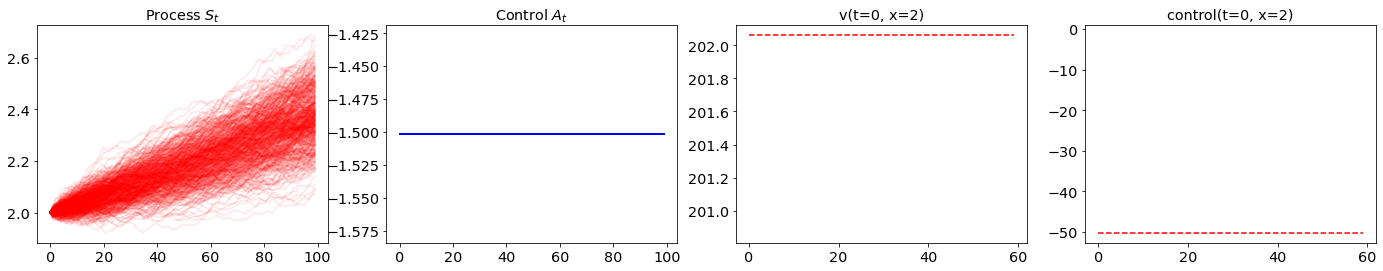

  2%|▋                                         | 10/600 [00:01<01:01,  9.57it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 201.3 
 theoretical constant optimal control: -50.25


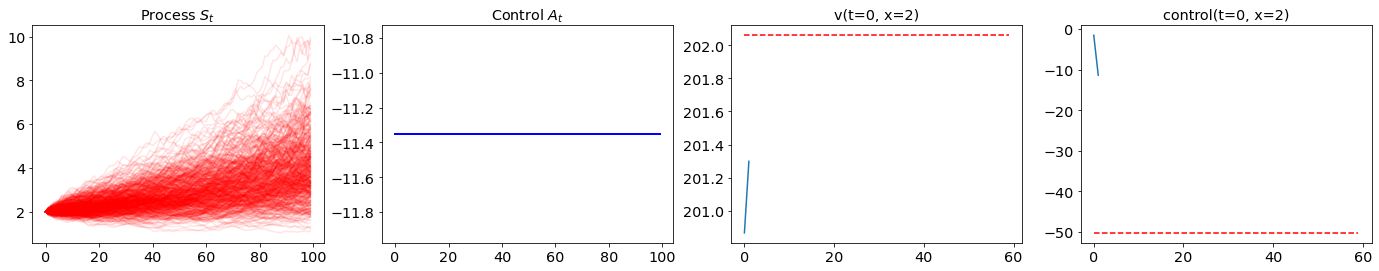

  3%|█▍                                        | 20/600 [00:03<01:03,  9.19it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 201.64 
 theoretical constant optimal control: -50.25


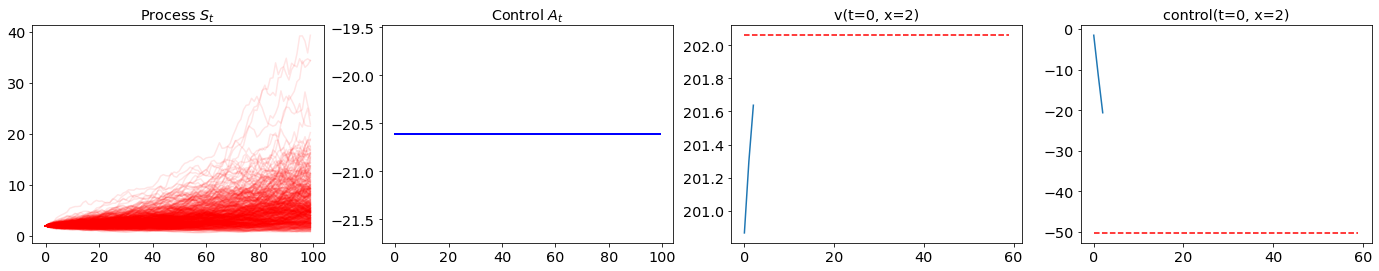

  5%|██                                        | 30/600 [00:05<01:02,  9.07it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 201.8 
 theoretical constant optimal control: -50.25


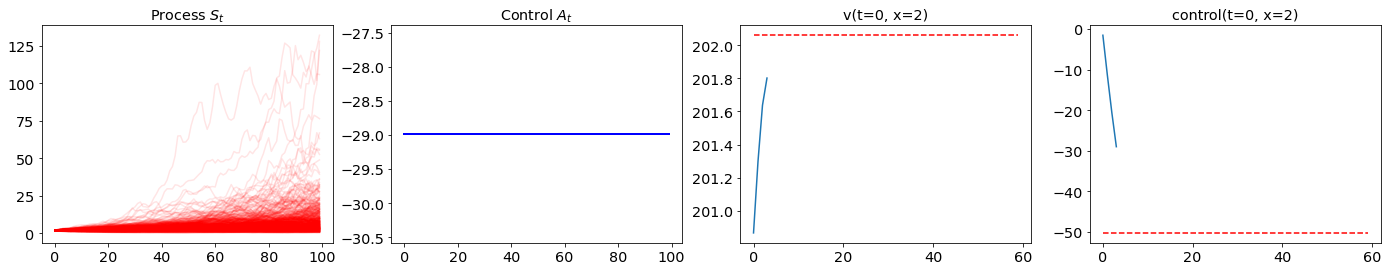

  7%|██▊                                       | 40/600 [00:06<01:01,  9.10it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 201.9 
 theoretical constant optimal control: -50.25


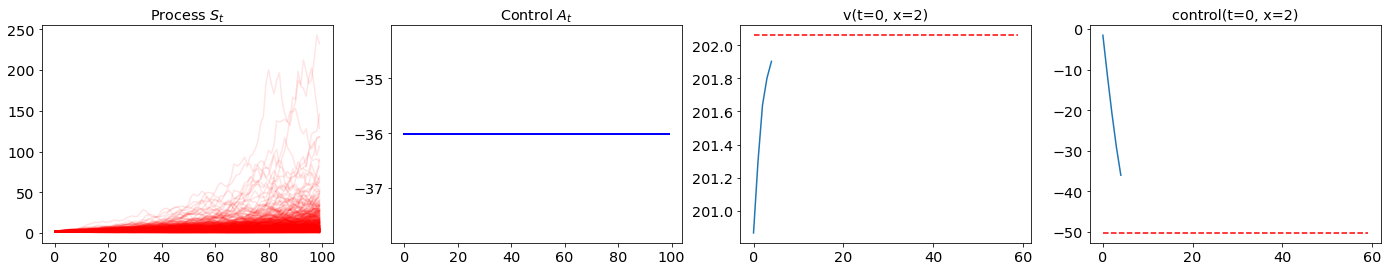

  8%|███▌                                      | 50/600 [00:08<00:59,  9.22it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.04 
 theoretical constant optimal control: -50.25


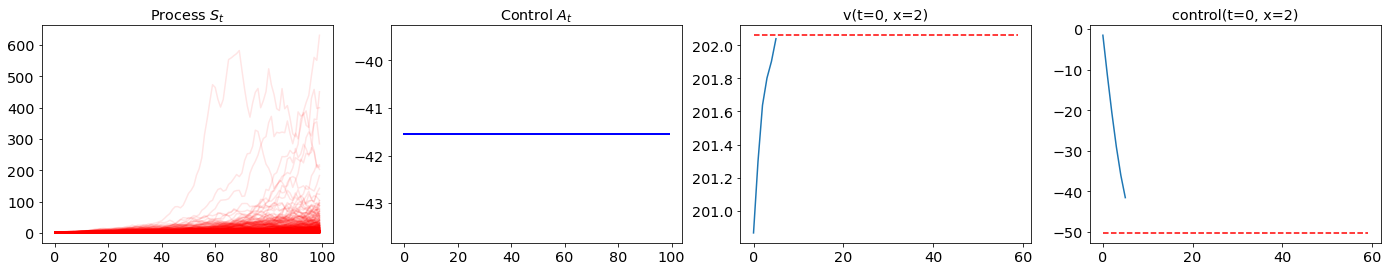

 10%|████▏                                     | 60/600 [00:09<00:56,  9.54it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.03 
 theoretical constant optimal control: -50.25


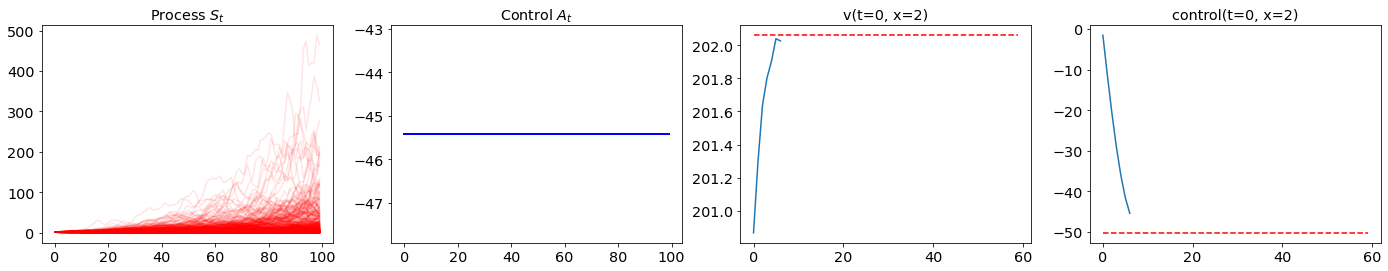

 12%|████▉                                     | 70/600 [00:11<00:56,  9.39it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.09 
 theoretical constant optimal control: -50.25


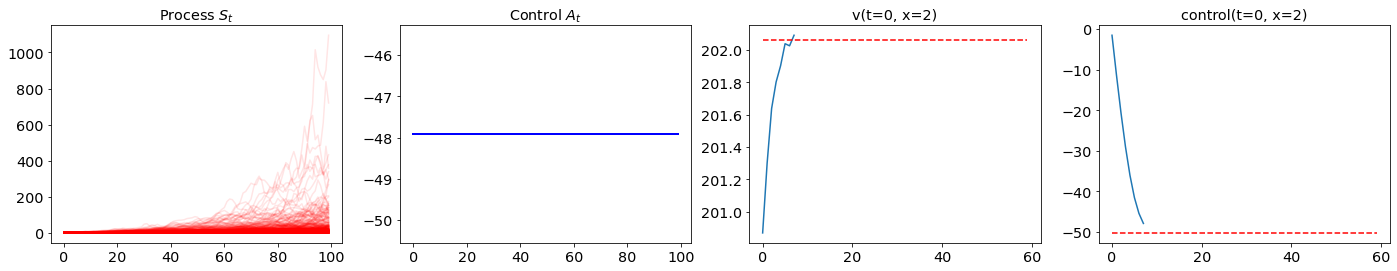

 13%|█████▌                                    | 80/600 [00:12<00:56,  9.14it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.12 
 theoretical constant optimal control: -50.25


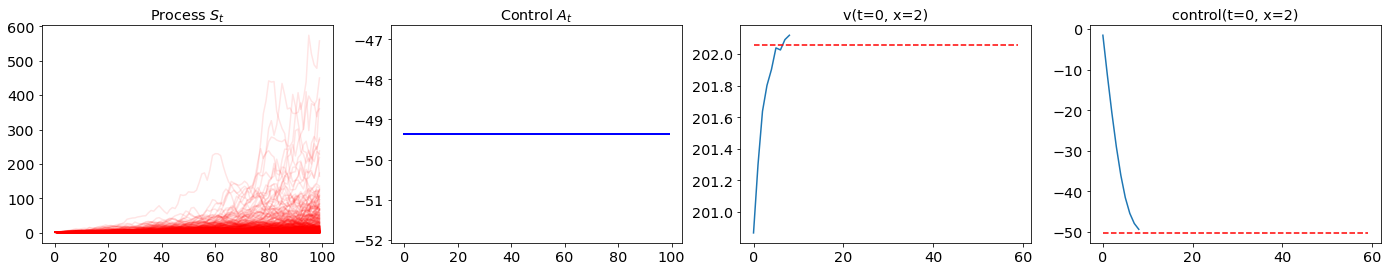

 15%|██████▎                                   | 90/600 [00:14<00:55,  9.26it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.1 
 theoretical constant optimal control: -50.25


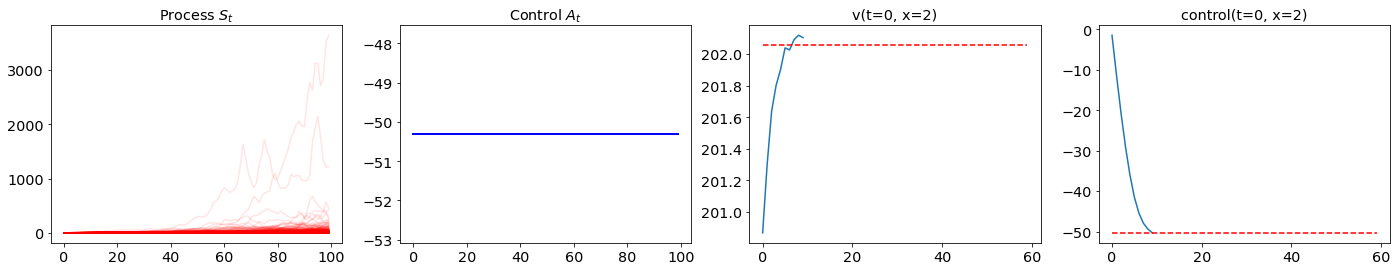

 17%|██████▊                                  | 100/600 [00:16<00:53,  9.37it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 201.98 
 theoretical constant optimal control: -50.25


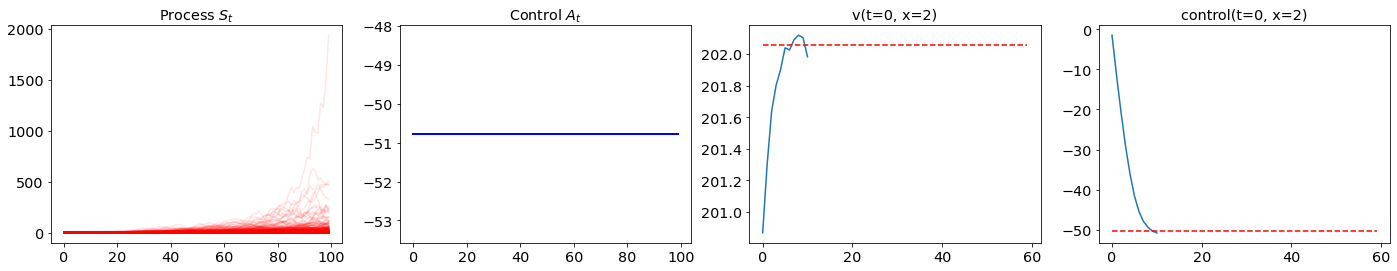

 18%|███████▌                                 | 110/600 [00:17<00:53,  9.19it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 201.91 
 theoretical constant optimal control: -50.25


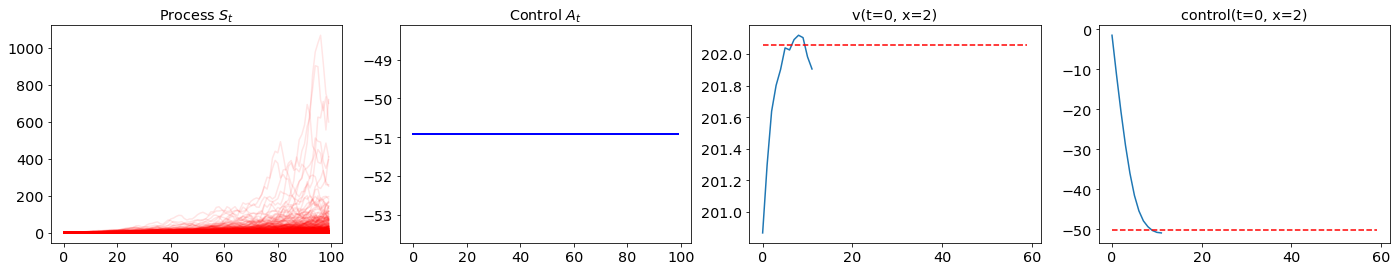

 20%|████████▏                                | 120/600 [00:19<00:53,  8.92it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 201.91 
 theoretical constant optimal control: -50.25


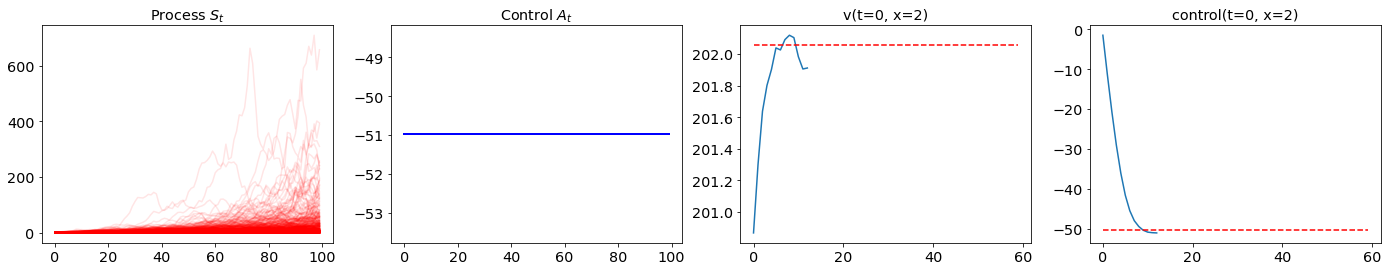

 22%|████████▉                                | 130/600 [00:20<00:51,  9.17it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.11 
 theoretical constant optimal control: -50.25


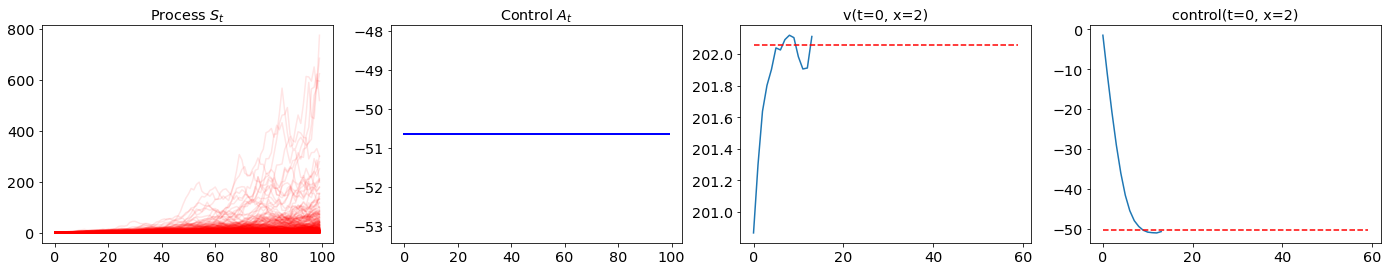

 23%|█████████▌                               | 140/600 [00:22<00:49,  9.20it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.06 
 theoretical constant optimal control: -50.25


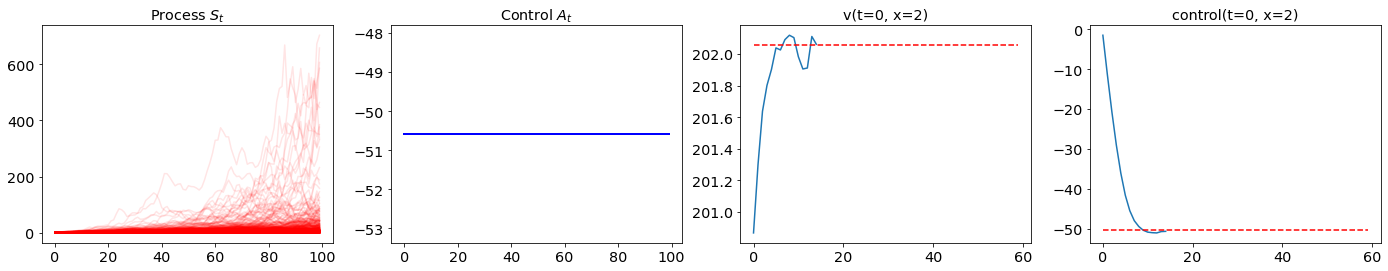

 25%|██████████▎                              | 150/600 [00:24<00:48,  9.26it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.24 
 theoretical constant optimal control: -50.25


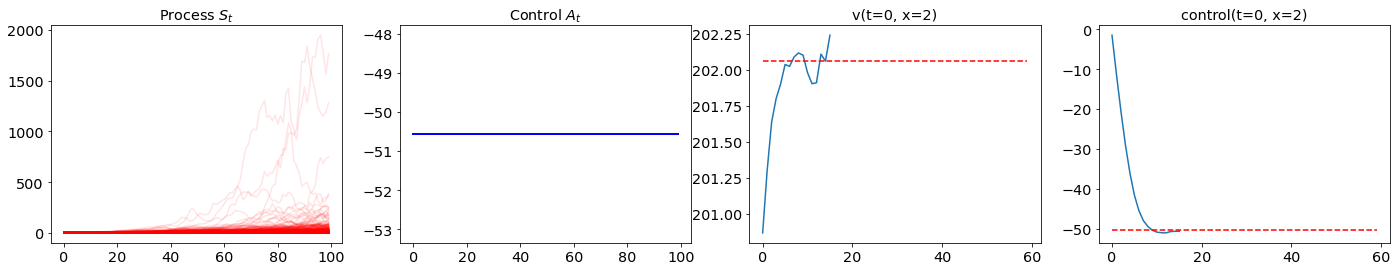

 27%|██████████▉                              | 160/600 [00:25<00:46,  9.39it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 201.95 
 theoretical constant optimal control: -50.25


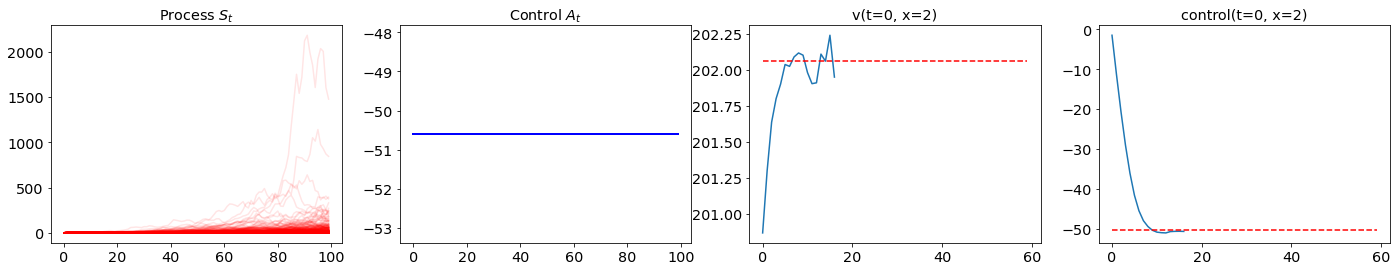

 28%|███████████▌                             | 170/600 [00:27<00:46,  9.34it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 201.97 
 theoretical constant optimal control: -50.25


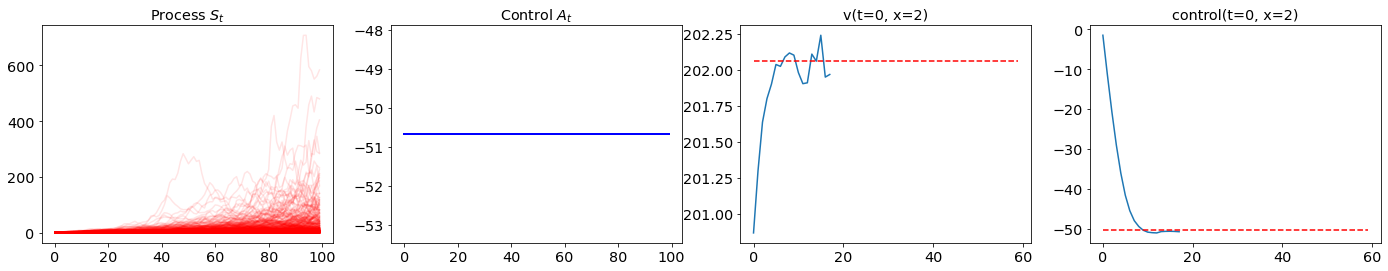

 30%|████████████▎                            | 180/600 [00:28<00:45,  9.29it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 201.92 
 theoretical constant optimal control: -50.25


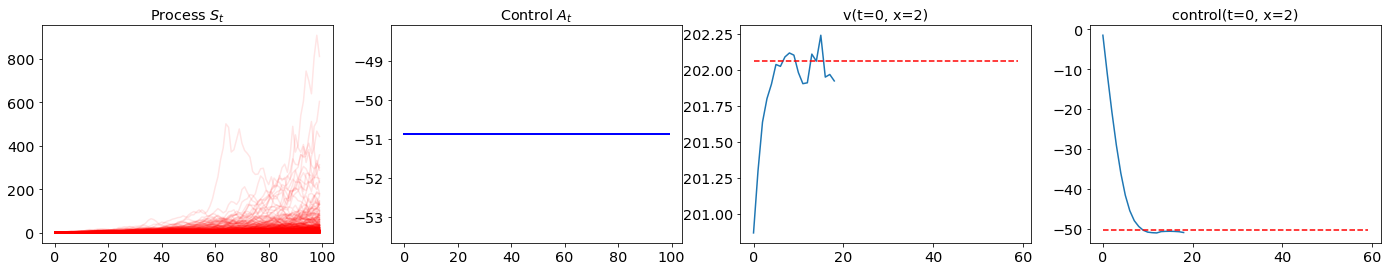

 32%|████████████▉                            | 190/600 [00:30<00:45,  8.94it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.05 
 theoretical constant optimal control: -50.25


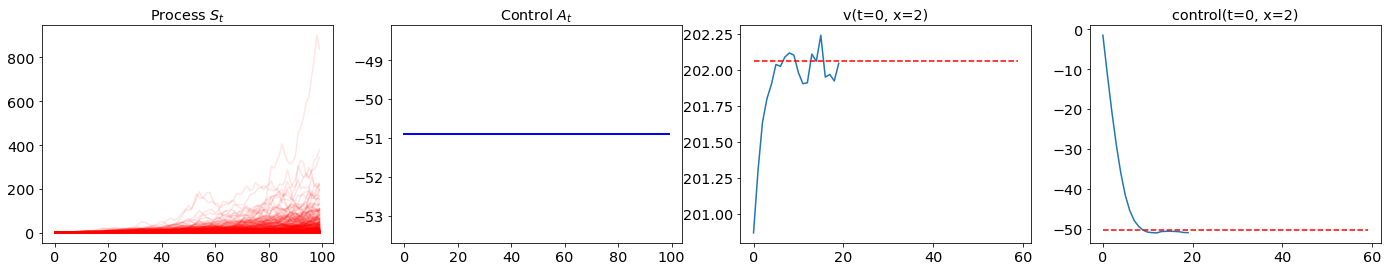

 33%|█████████████▋                           | 200/600 [00:32<00:42,  9.30it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.07 
 theoretical constant optimal control: -50.25


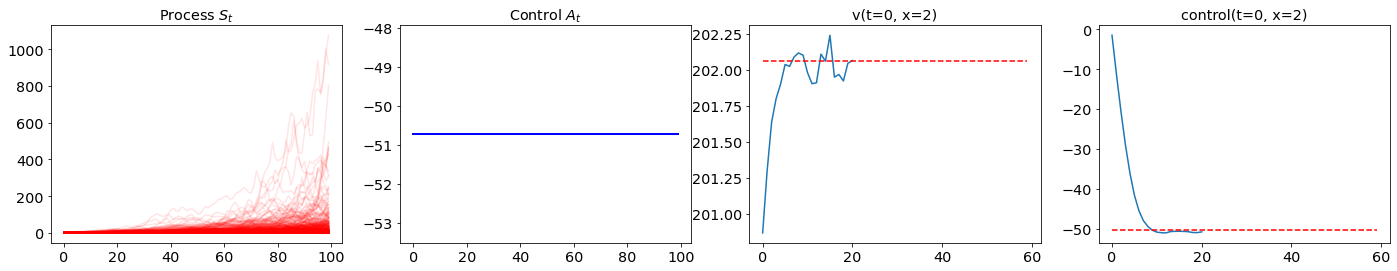

 35%|██████████████▎                          | 210/600 [00:33<00:42,  9.22it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.0 
 theoretical constant optimal control: -50.25


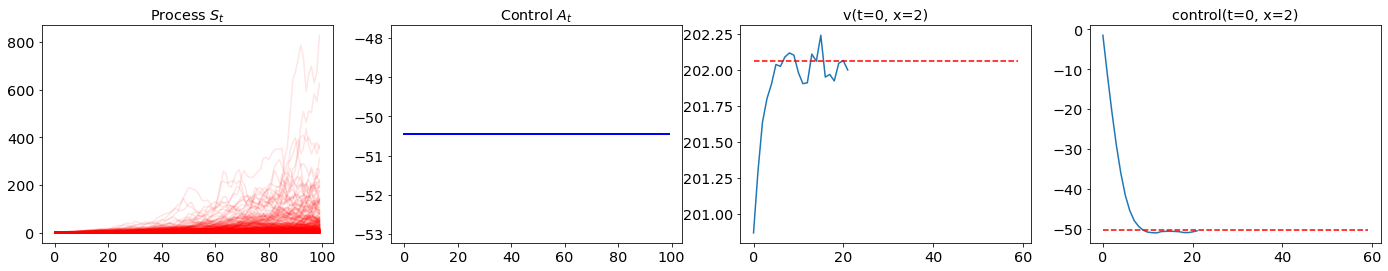

 37%|███████████████                          | 220/600 [00:35<00:41,  9.18it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.15 
 theoretical constant optimal control: -50.25


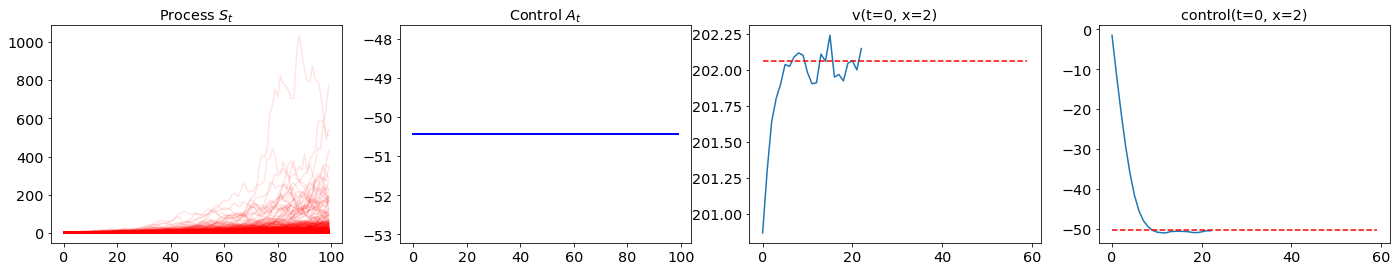

 38%|███████████████▋                         | 230/600 [00:36<00:40,  9.13it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.22 
 theoretical constant optimal control: -50.25


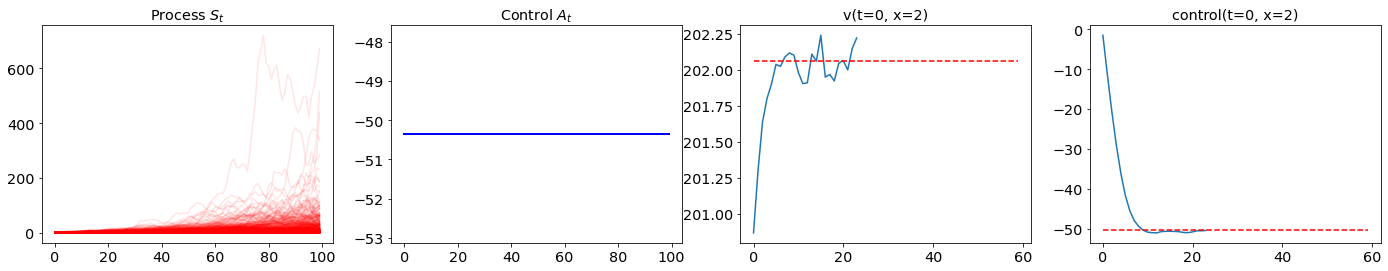

 40%|████████████████▍                        | 240/600 [00:38<00:38,  9.42it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 201.98 
 theoretical constant optimal control: -50.25


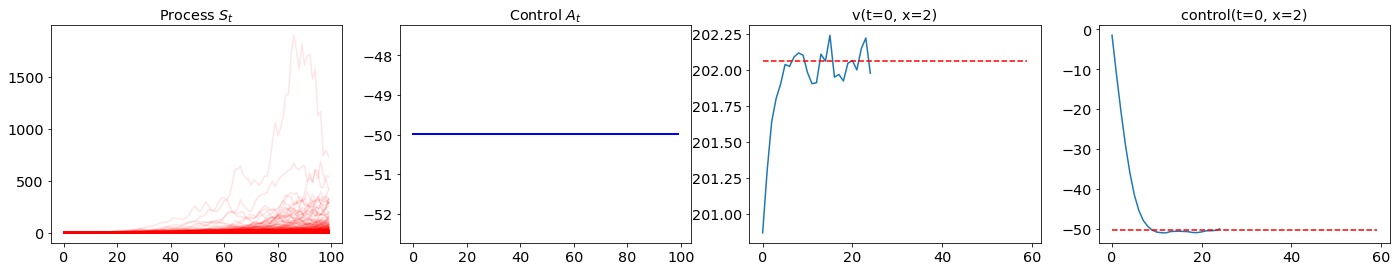

 42%|█████████████████                        | 250/600 [00:39<00:37,  9.36it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 201.98 
 theoretical constant optimal control: -50.25


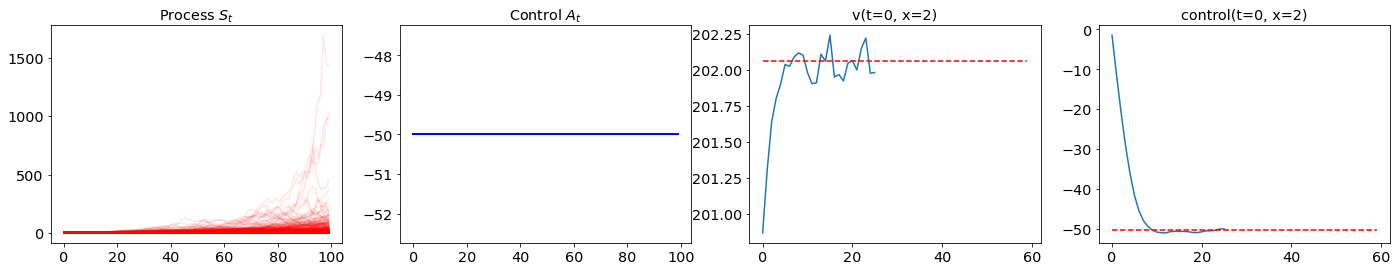

 43%|█████████████████▊                       | 260/600 [00:41<00:36,  9.41it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.04 
 theoretical constant optimal control: -50.25


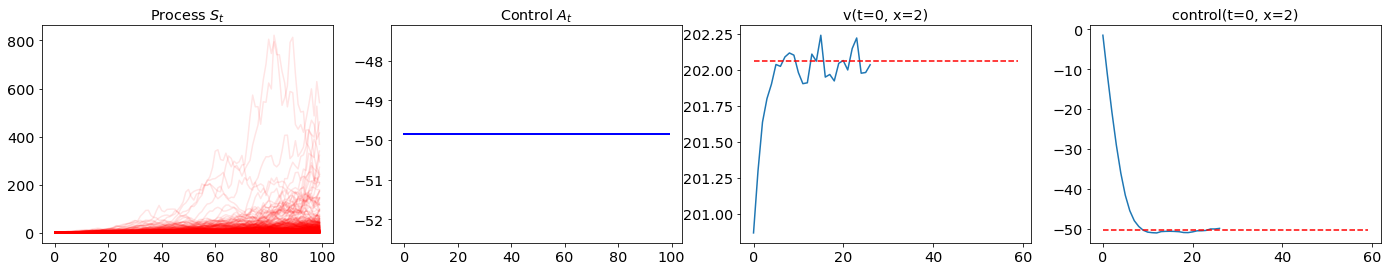

 45%|██████████████████▍                      | 270/600 [00:43<00:35,  9.33it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.18 
 theoretical constant optimal control: -50.25


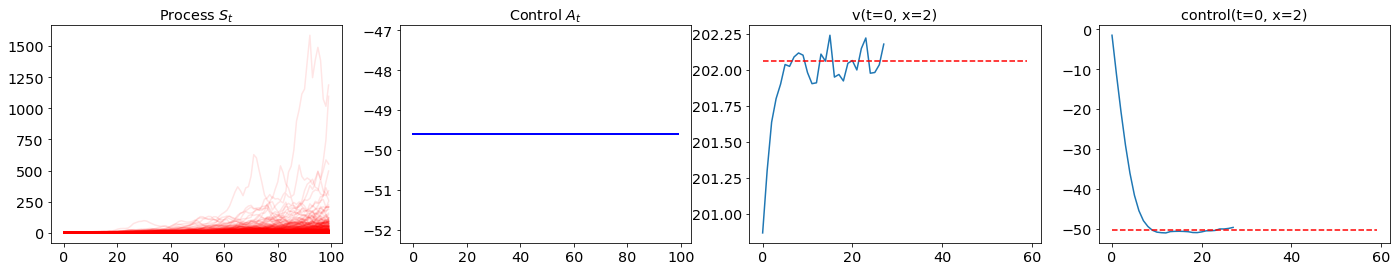

 47%|███████████████████▏                     | 280/600 [00:44<00:34,  9.34it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.02 
 theoretical constant optimal control: -50.25


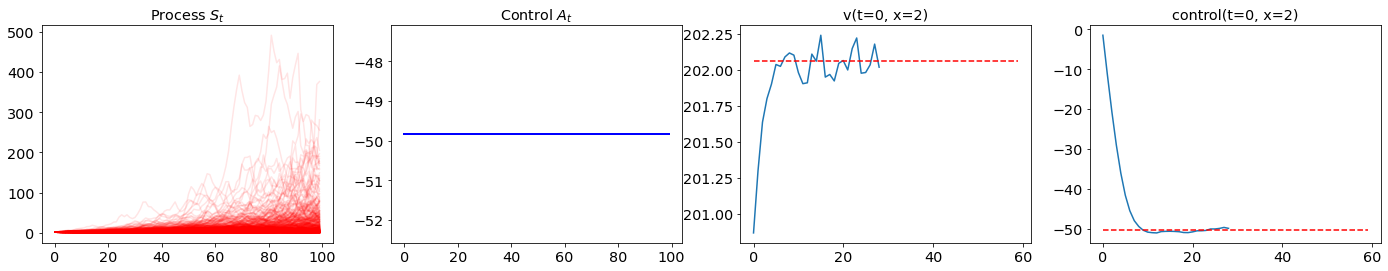

 48%|███████████████████▊                     | 290/600 [00:46<00:33,  9.39it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.08 
 theoretical constant optimal control: -50.25


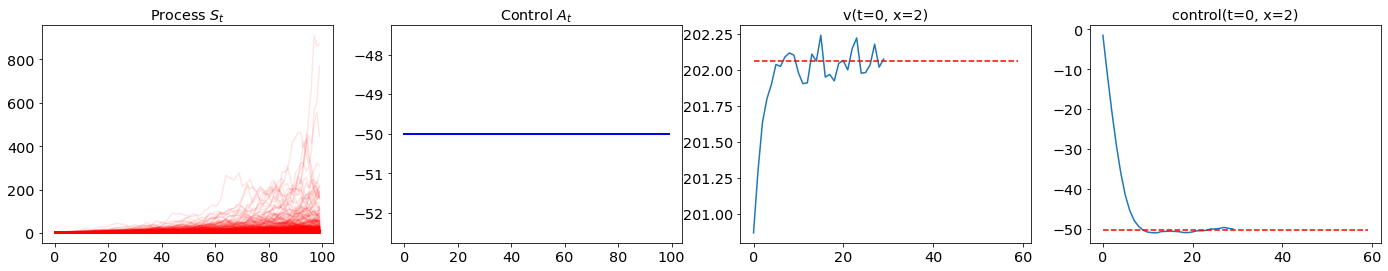

 50%|████████████████████▌                    | 300/600 [00:47<00:34,  8.78it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.0 
 theoretical constant optimal control: -50.25


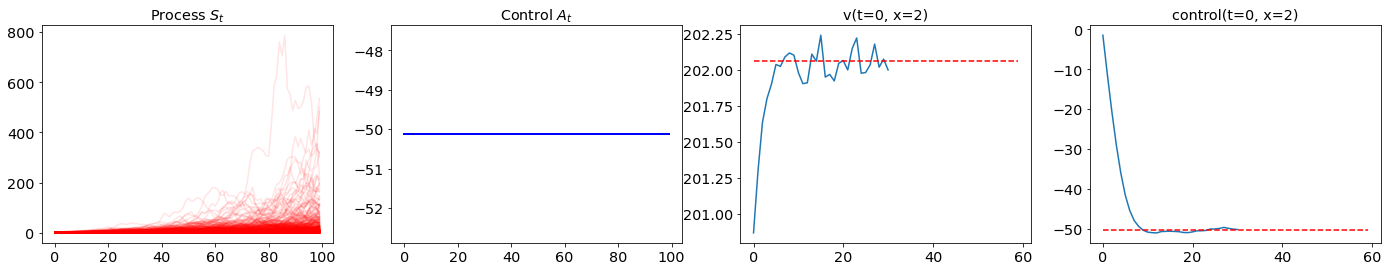

 52%|█████████████████████▏                   | 310/600 [00:49<00:31,  9.12it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.07 
 theoretical constant optimal control: -50.25


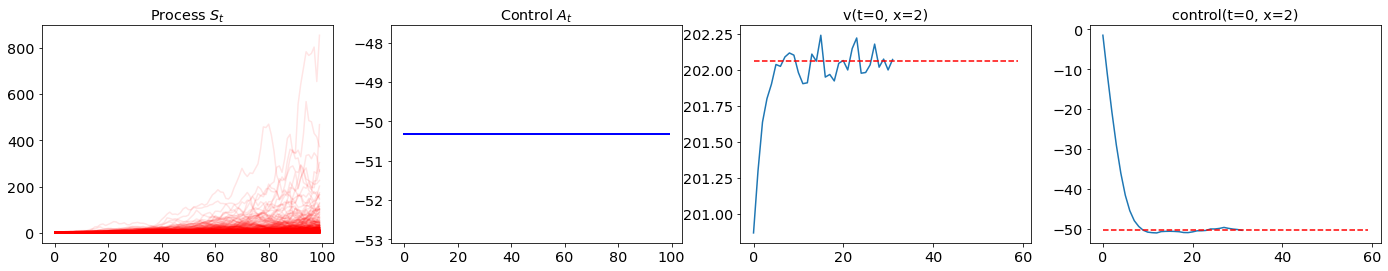

 53%|█████████████████████▊                   | 320/600 [00:51<00:30,  9.15it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.14 
 theoretical constant optimal control: -50.25


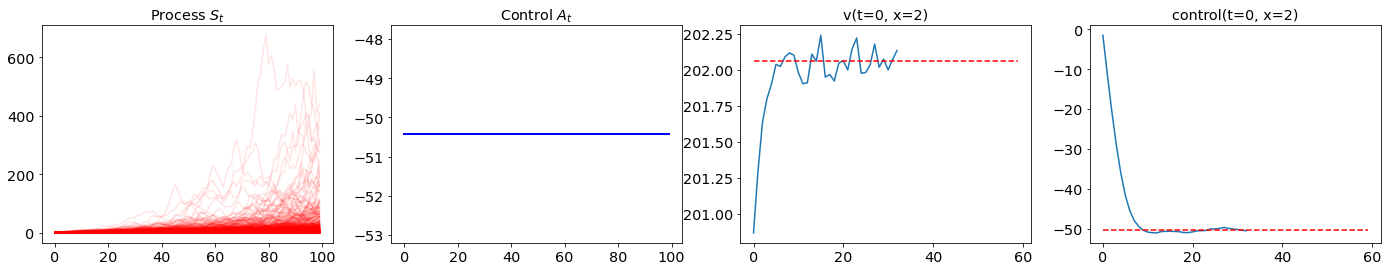

 55%|██████████████████████▌                  | 330/600 [00:52<00:29,  9.07it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.06 
 theoretical constant optimal control: -50.25


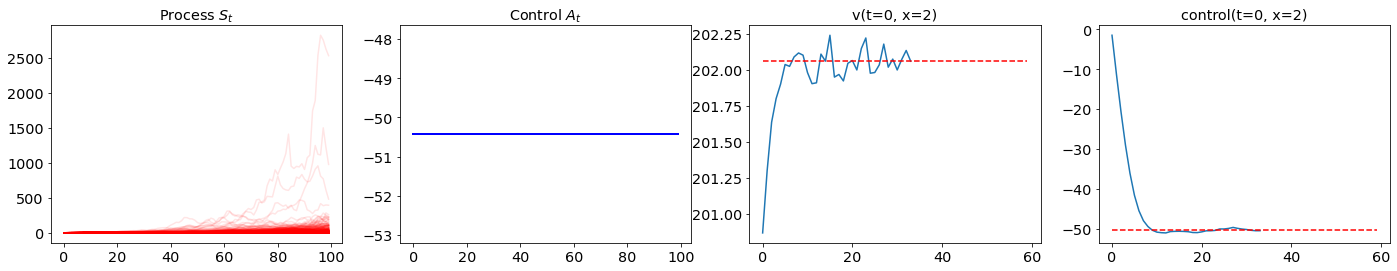

 57%|███████████████████████▏                 | 340/600 [00:54<00:28,  9.10it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.01 
 theoretical constant optimal control: -50.25


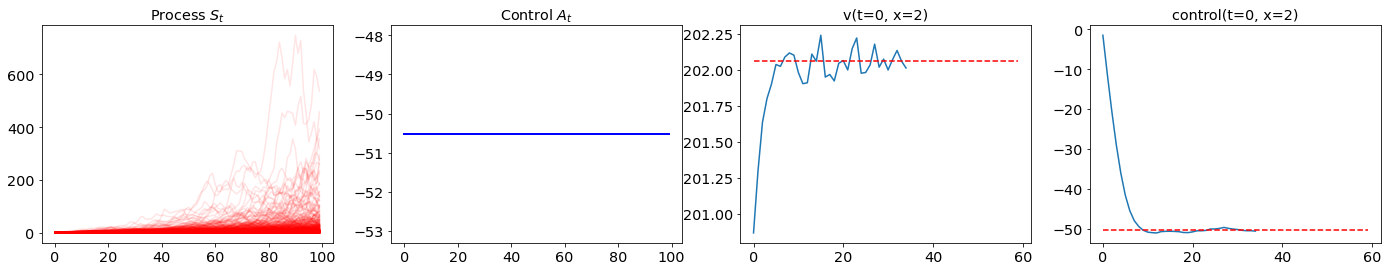

 58%|███████████████████████▉                 | 350/600 [00:55<00:26,  9.39it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.15 
 theoretical constant optimal control: -50.25


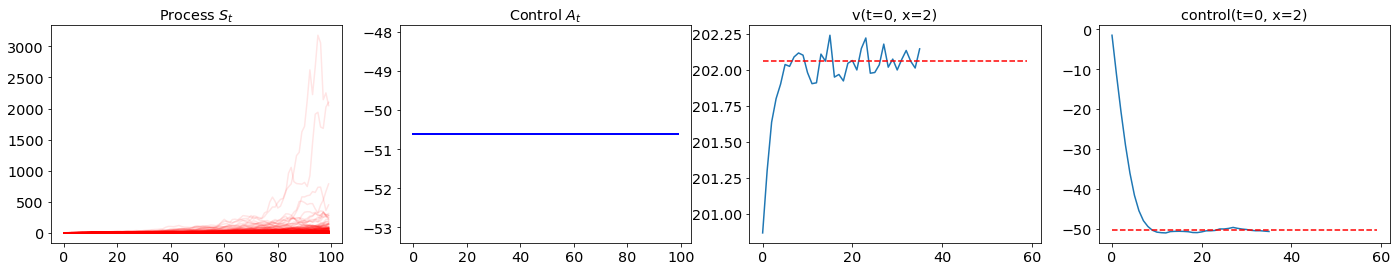

 60%|████████████████████████▌                | 360/600 [00:57<00:26,  9.21it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.11 
 theoretical constant optimal control: -50.25


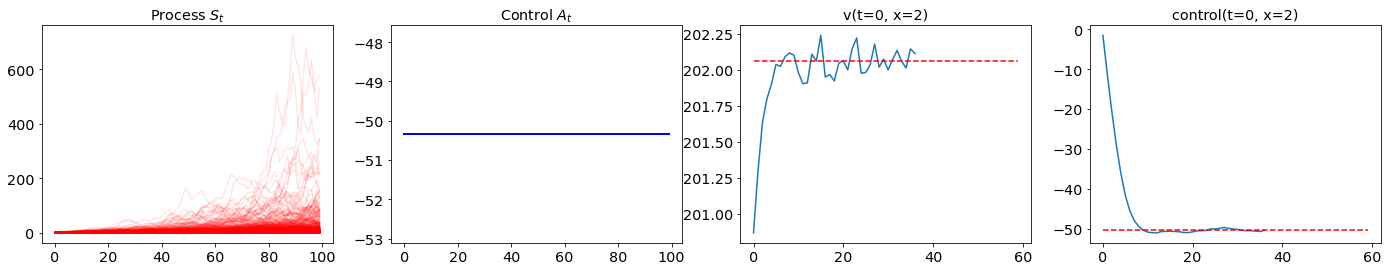

 62%|█████████████████████████▎               | 370/600 [00:59<00:25,  9.17it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.03 
 theoretical constant optimal control: -50.25


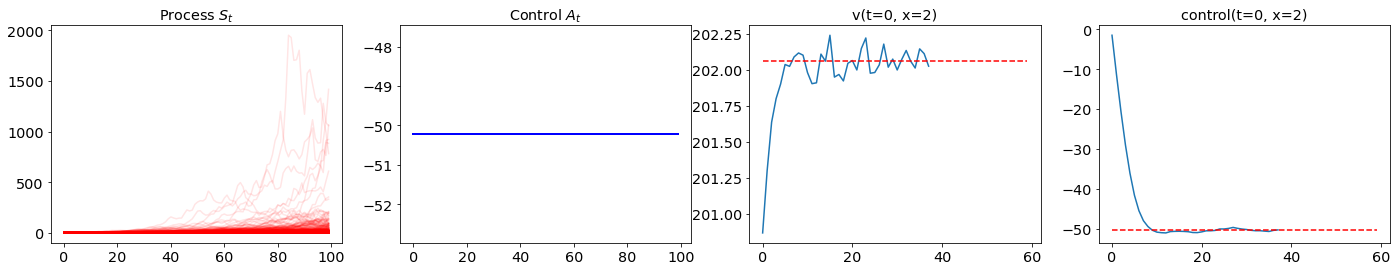

 63%|█████████████████████████▉               | 380/600 [01:00<00:24,  9.06it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.13 
 theoretical constant optimal control: -50.25


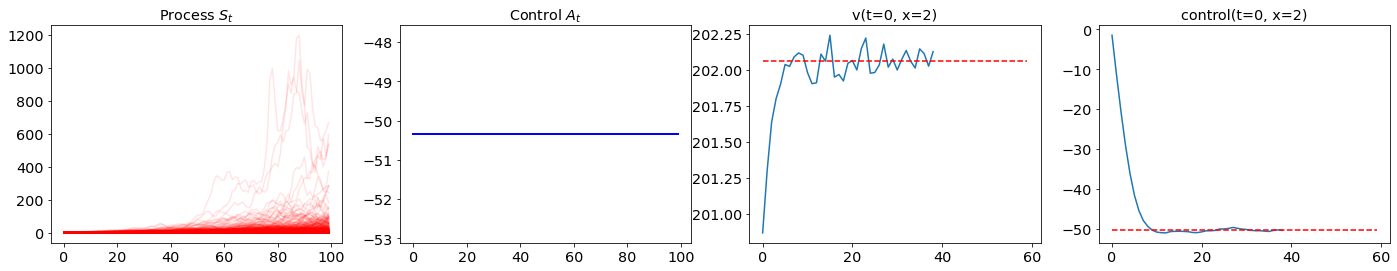

 65%|██████████████████████████▋              | 390/600 [01:02<00:22,  9.27it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.04 
 theoretical constant optimal control: -50.25


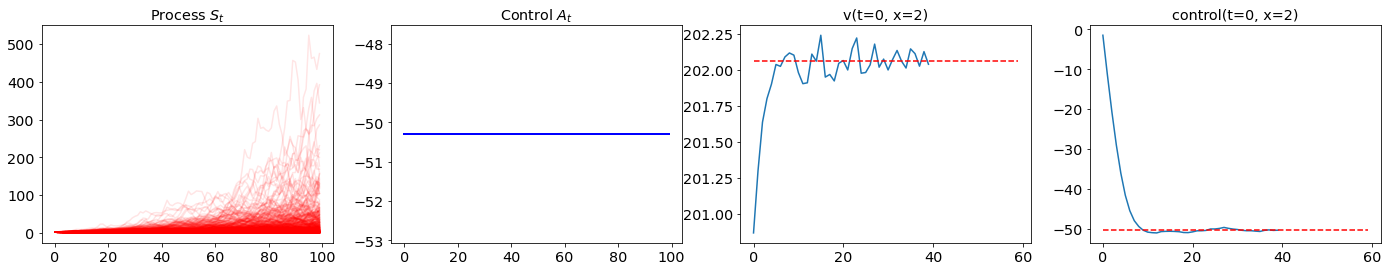

 67%|███████████████████████████▎             | 400/600 [01:03<00:21,  9.40it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.14 
 theoretical constant optimal control: -50.25


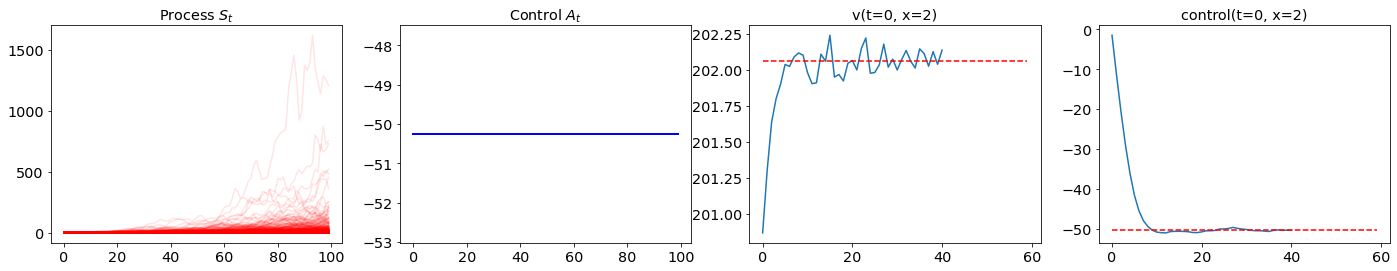

 68%|████████████████████████████             | 410/600 [01:05<00:21,  9.02it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.02 
 theoretical constant optimal control: -50.25


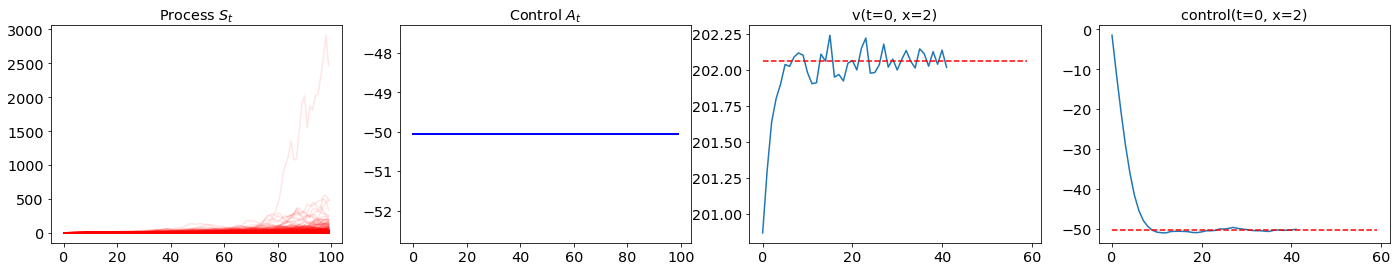

 70%|████████████████████████████▋            | 420/600 [01:07<00:19,  9.32it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.02 
 theoretical constant optimal control: -50.25


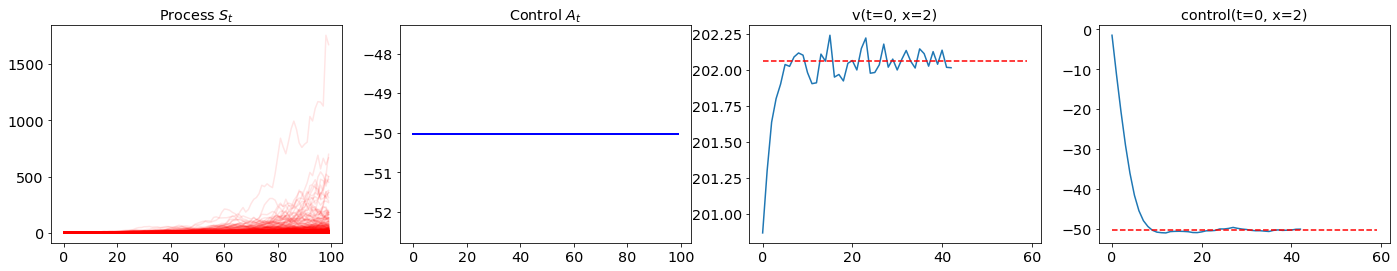

 72%|█████████████████████████████▍           | 430/600 [01:08<00:18,  9.33it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.13 
 theoretical constant optimal control: -50.25


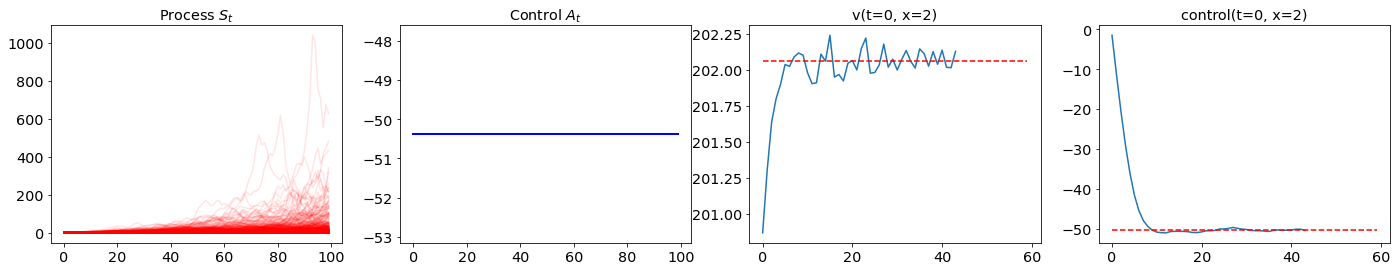

 73%|██████████████████████████████           | 440/600 [01:10<00:17,  9.34it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.06 
 theoretical constant optimal control: -50.25


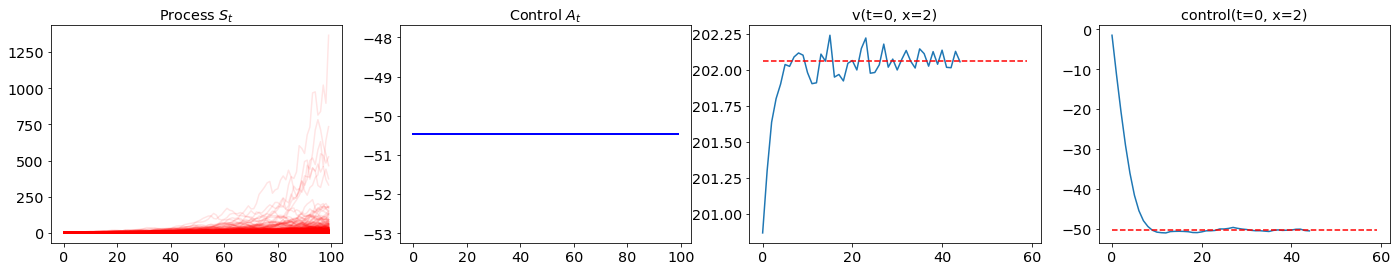

 75%|██████████████████████████████▊          | 450/600 [01:11<00:16,  9.19it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.08 
 theoretical constant optimal control: -50.25


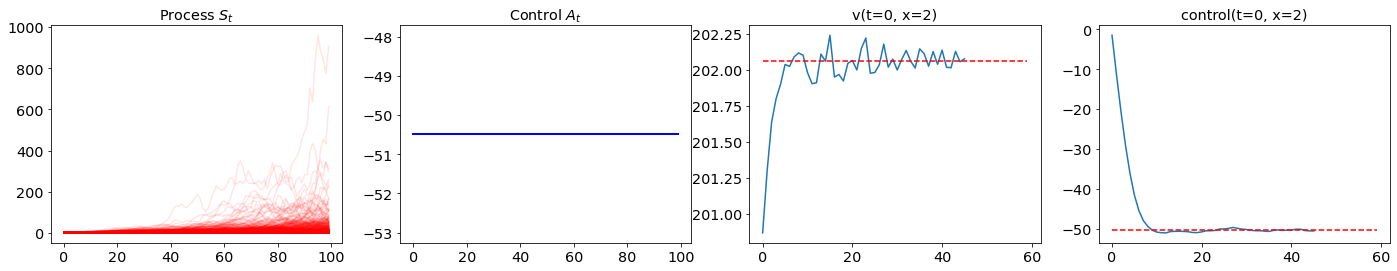

 77%|███████████████████████████████▍         | 460/600 [01:13<00:14,  9.49it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 201.99 
 theoretical constant optimal control: -50.25


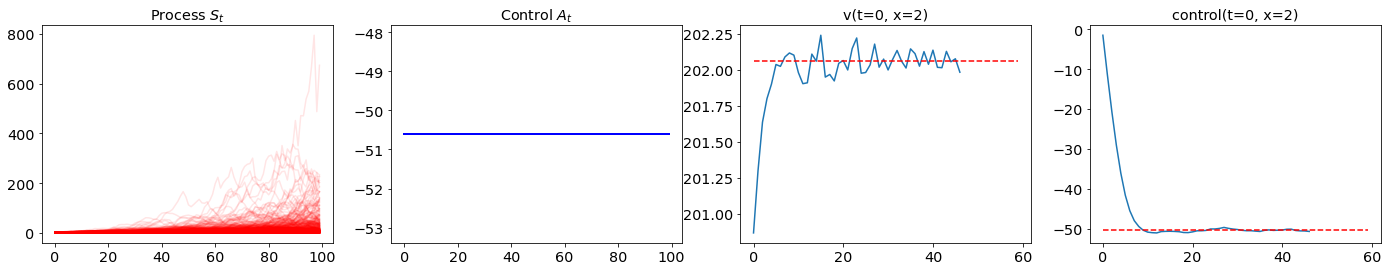

 78%|████████████████████████████████         | 470/600 [01:14<00:13,  9.55it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.04 
 theoretical constant optimal control: -50.25


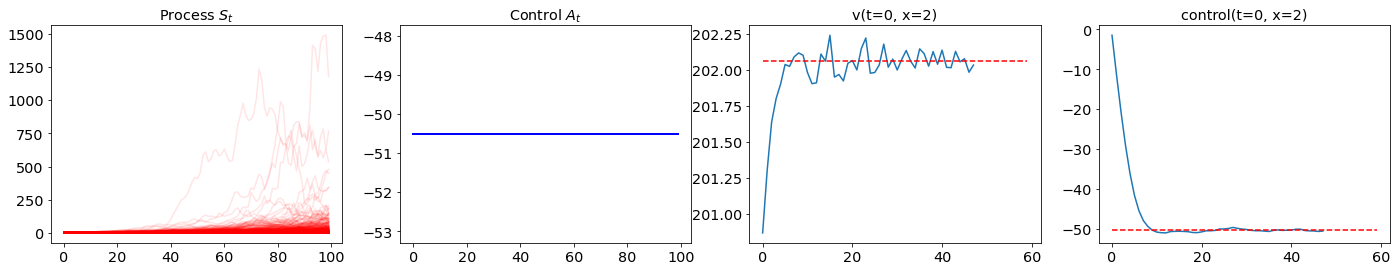

 80%|████████████████████████████████▊        | 480/600 [01:16<00:12,  9.35it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 201.97 
 theoretical constant optimal control: -50.25


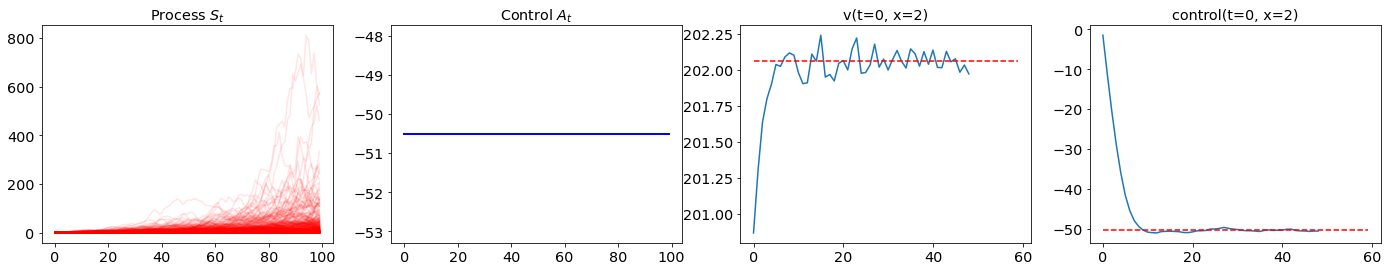

 82%|█████████████████████████████████▍       | 490/600 [01:18<00:11,  9.28it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.04 
 theoretical constant optimal control: -50.25


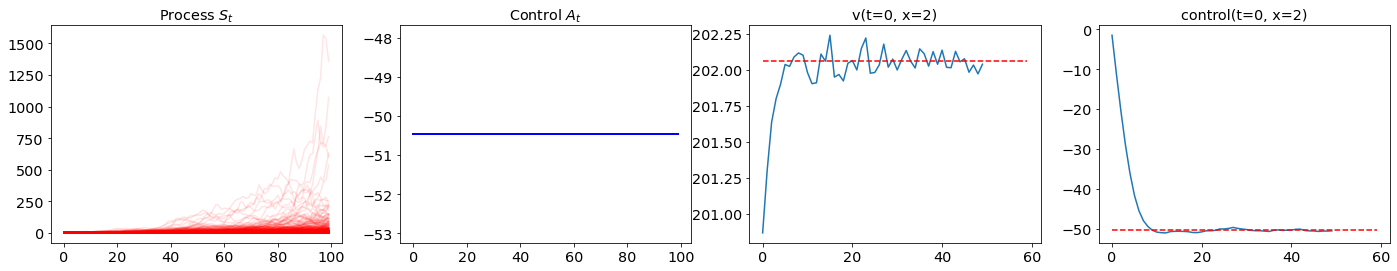

 83%|██████████████████████████████████▏      | 500/600 [01:19<00:10,  9.40it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.02 
 theoretical constant optimal control: -50.25


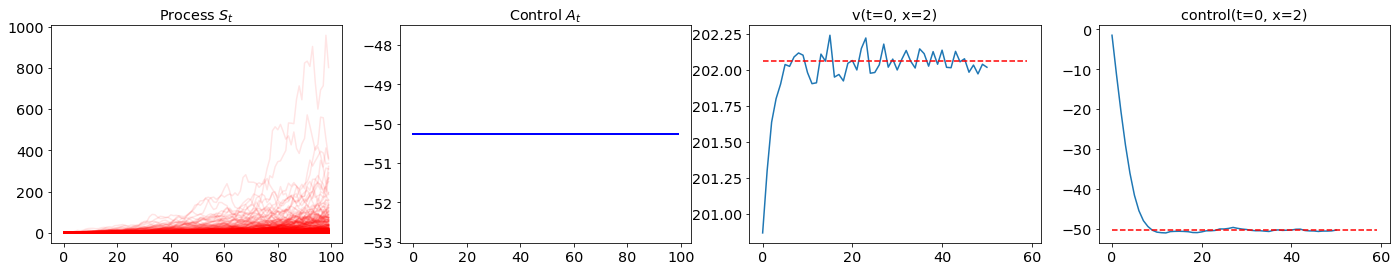

 85%|██████████████████████████████████▊      | 510/600 [01:21<00:09,  9.50it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.13 
 theoretical constant optimal control: -50.25


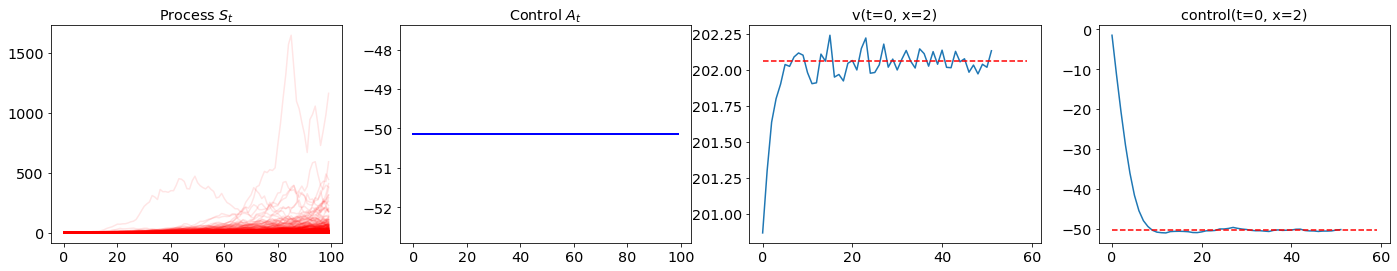

 87%|███████████████████████████████████▌     | 520/600 [01:22<00:08,  9.06it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.04 
 theoretical constant optimal control: -50.25


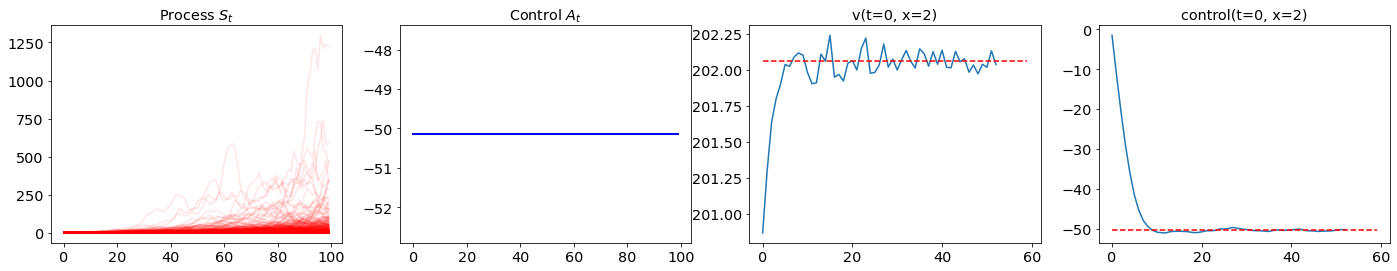

 88%|████████████████████████████████████▏    | 530/600 [01:24<00:07,  9.38it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.04 
 theoretical constant optimal control: -50.25


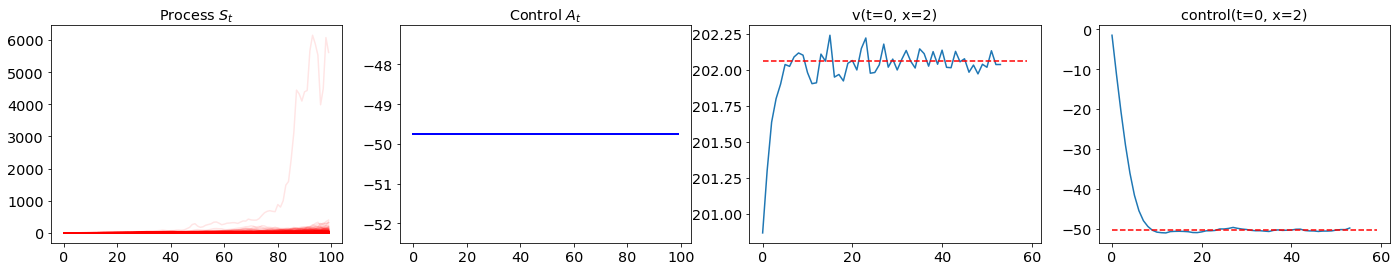

 90%|████████████████████████████████████▉    | 540/600 [01:25<00:06,  9.33it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 201.97 
 theoretical constant optimal control: -50.25


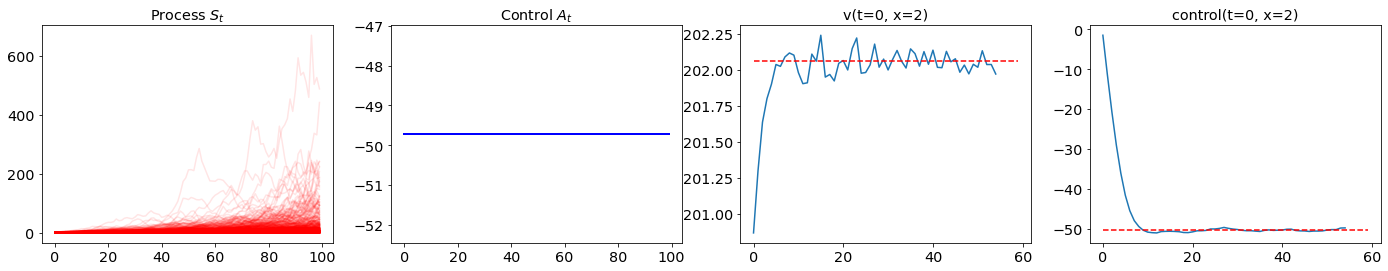

 92%|█████████████████████████████████████▌   | 550/600 [01:27<00:05,  9.49it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.03 
 theoretical constant optimal control: -50.25


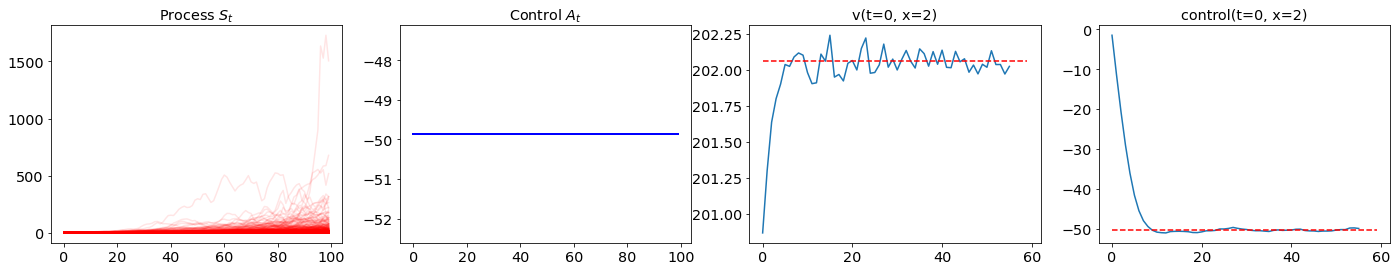

 93%|██████████████████████████████████████▎  | 560/600 [01:29<00:04,  9.36it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.13 
 theoretical constant optimal control: -50.25


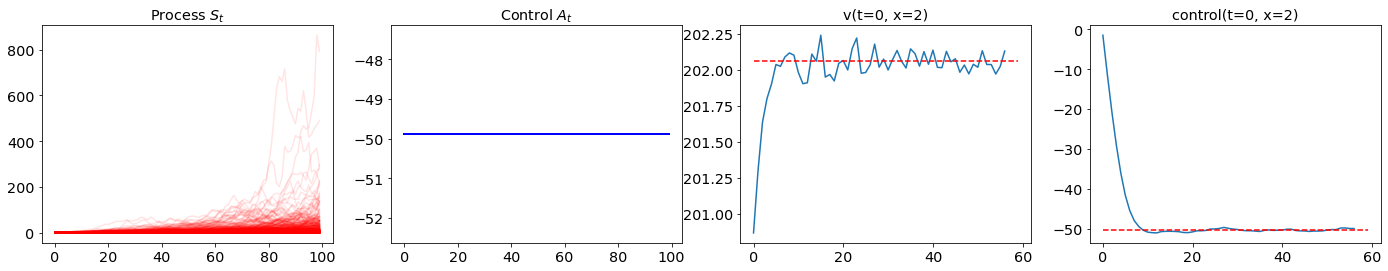

 95%|██████████████████████████████████████▉  | 570/600 [01:30<00:03,  9.60it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.11 
 theoretical constant optimal control: -50.25


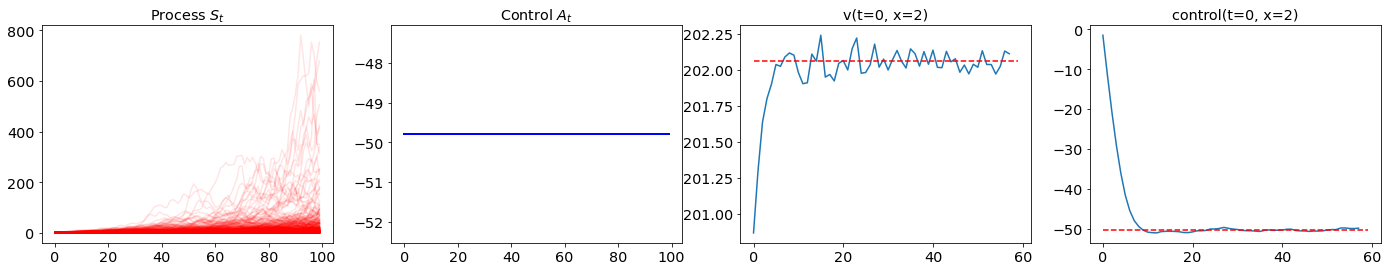

 97%|███████████████████████████████████████▋ | 580/600 [01:32<00:02,  9.43it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.0 
 theoretical constant optimal control: -50.25


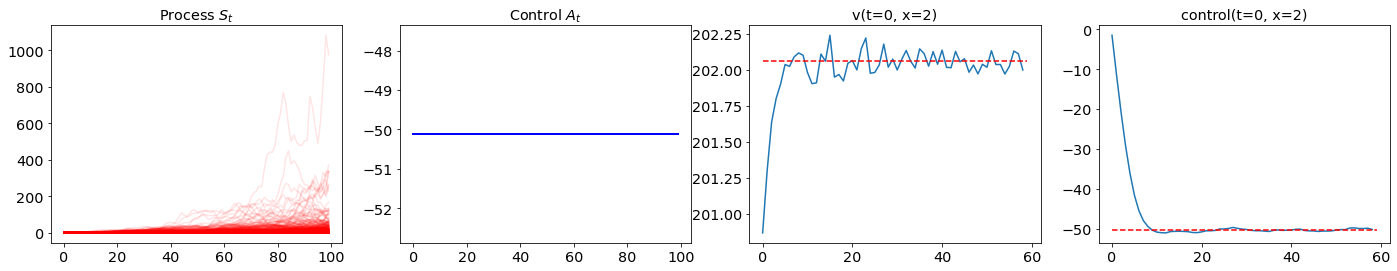

 98%|████████████████████████████████████████▎| 590/600 [01:33<00:01,  9.36it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 201.93 
 theoretical constant optimal control: -50.25


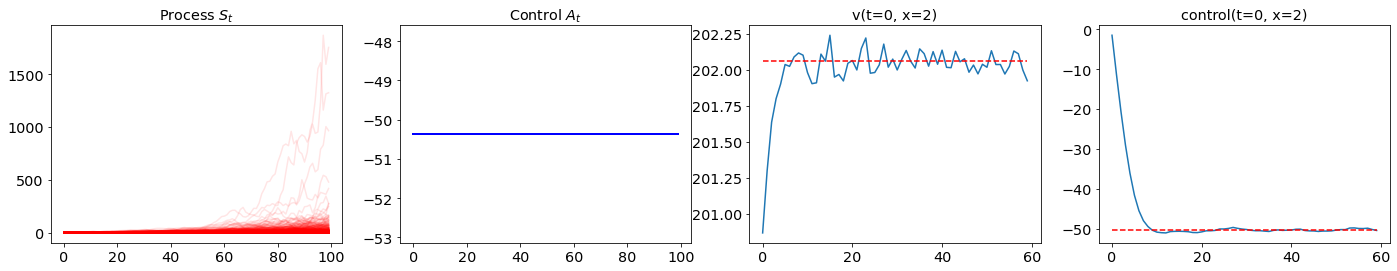

100%|████████████████████████████████████████▊| 598/600 [01:35<00:00,  8.01it/s]

 
 initial condition: 2 
 theoretical value function: 202.06 
 predicted value function: 202.06 
 theoretical constant optimal control: -50.25


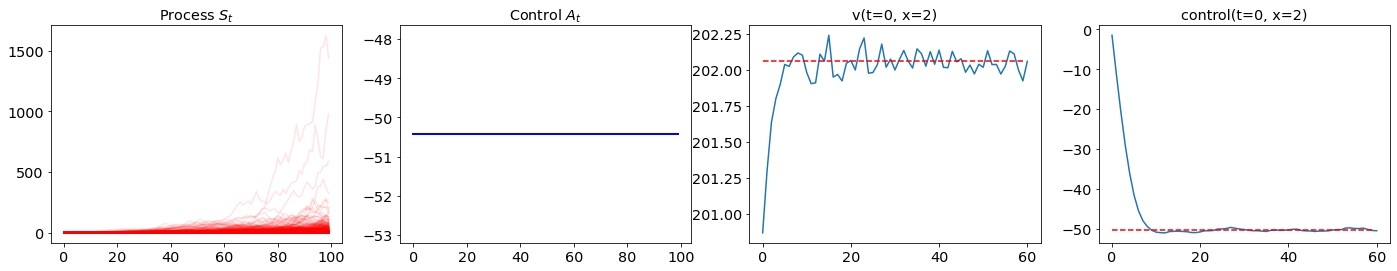

100%|█████████████████████████████████████████| 600/600 [01:36<00:00,  6.24it/s]


In [13]:
# training loop
trange = tqdm.tqdm(range(iterations))

for step in trange:

    # random initial condition
#     s0 = np.random.uniform(low=1.5, high=2.5)
    s0 = 2
    x0_batch = np.log(s0)*torch.ones(batch_size, 1, device=device)

    optimiser.zero_grad()
    
    generated_samples = model(x0_batch, ts)

    x = generated_samples[...,0]
    
    s_T = torch.exp(x[:,-1])
    
    loss = -torch.mean(s_T**p/p)

    loss.backward()

    optimiser.step()
    
    scheduler.step()

    if (step % iterations_per_print) == 0 or step == iterations - 1:
        with torch.no_grad():

            # random initial condition
            # s0 = np.random.uniform(low=1.0, high=2.0)

            # theoretical optimal control and value function v(t=0,s=s_0)
            a = (mu-r)/((sigma**2)*(1.-p))
            rho = p*((mu-r)**2)/(2.*(sigma**2)*(1.-p)) + r*p
            v = np.exp(rho*T)*(s0**p/p)

            x0_batch = np.log(s0)*torch.ones(batch_size, 1, device=device)

            generated_samples = model(x0_batch, ts)

            x = generated_samples[...,0]
            s_T = torch.exp(x[:,-1])
            z = generated_samples[...,1:]
        
            alpha = torch.mean(torch.tensor(model._func.A_theta(z).cpu().numpy()))
            
            loss = torch.mean(s_T**p/p)
#             print(alpha)
#             print(loss)
            v_theo = np.round(v,2)
            a_theo = np.round(a,2)

            # print the two theoretical solution line
            v_list = []
            a_list = []
            for i in range(times):
                v_list.append(v_theo)
                a_list.append(a_theo)
            
            print(f' \n initial condition: {np.round(s0,2)} \n',
                  f'theoretical value function: {v_theo} \n', 
                  f'predicted value function: {np.round(loss.cpu().numpy().item(),2)} \n',
                  f'theoretical constant optimal control: {a_theo}'
                  )

            losses.append(loss)
            controls.append(alpha)

            results_plot(model, x0_batch, losses, controls, T, batch_size, t_size_test, v_list, a_list, times)

In [14]:
controls

[tensor(-1.5016),
 tensor(-11.3522),
 tensor(-20.6127),
 tensor(-28.9869),
 tensor(-36.0161),
 tensor(-41.5483),
 tensor(-45.4179),
 tensor(-47.9141),
 tensor(-49.3645),
 tensor(-50.3106),
 tensor(-50.7807),
 tensor(-50.9201),
 tensor(-50.9766),
 tensor(-50.6467),
 tensor(-50.5853),
 tensor(-50.5654),
 tensor(-50.6033),
 tensor(-50.6765),
 tensor(-50.8776),
 tensor(-50.8998),
 tensor(-50.7181),
 tensor(-50.4489),
 tensor(-50.4383),
 tensor(-50.3527),
 tensor(-49.9883),
 tensor(-49.9901),
 tensor(-49.8468),
 tensor(-49.6013),
 tensor(-49.8333),
 tensor(-50.0102),
 tensor(-50.1270),
 tensor(-50.3246),
 tensor(-50.4262),
 tensor(-50.4252),
 tensor(-50.5248),
 tensor(-50.6133),
 tensor(-50.3407),
 tensor(-50.2191),
 tensor(-50.3436),
 tensor(-50.2994),
 tensor(-50.2532),
 tensor(-50.0611),
 tensor(-50.0361),
 tensor(-50.3779),
 tensor(-50.4697),
 tensor(-50.4855),
 tensor(-50.6065),
 tensor(-50.5168),
 tensor(-50.5146),
 tensor(-50.4637),
 tensor(-50.2620),
 tensor(-50.1446),
 tensor(-50.1

In [15]:
hfvhjvh.a

NameError: name 'hfvhjvh' is not defined

In [ ]:
import pandas as pd
# change data type to float
controls_ = list(map(float,controls))
losses_ = list(map(float,losses))

In [ ]:
# 导入CSV模块
import csv
# first time write data in csv.
 
# 1. 创建文件对象（指定文件名，模式，编码方式）
# with open("p1_controls.csv", "w", encoding="gbk", newline="") as f:
with open("p1_controls.csv", "w") as f:
    # 2. 基于文件对象构建 csv写入对象
    csv_writer = csv.writer(f)
#     # 3. 构建列表头
    csv_writer.writerow(range(1,42))
    # 4. 写入csv文件内容
    csv_writer.writerow(controls_)
    print("data save successful")
    # 5. 关闭文件
    f.close()
    
# 1. 创建文件对象（指定文件名，模式，编码方式）
# with open("p1_losses.csv", "w", encoding="gbk", newline="") as f:
with open("p1_losses.csv", "w") as f:
    # 2. 基于文件对象构建 csv写入对象
    csv_writer = csv.writer(f)
    # 3. 构建列表头
    csv_writer.writerow(range(1,42))
    # 4. 写入csv文件内容
    csv_writer.writerow(losses_)
    print("data save successful")
    # 5. 关闭文件
    f.close()



In [ ]:
# 导入CSV模块
import csv
# write new data
 
# 1. 创建文件对象（指定文件名，模式，编码方式）
# with open("p1_controls.csv", "a", encoding="gbk", newline="") as f:
with open("p1_controls.csv", "a") as f:
    # 2. 基于文件对象构建 csv写入对象
    csv_writer = csv.writer(f)
    # 3. 构建列表头
#     csv_writer.writerow(range(1,42))
    # 4. 写入csv文件内容
    csv_writer.writerow(controls_)
    print("data save successful")
    # 5. 关闭文件
    f.close()
    
# 1. 创建文件对象（指定文件名，模式，编码方式）
# with open("p1_losses.csv", "a", encoding="gbk", newline="") as f:
with open("p1_losses.csv", "a") as f:
    # 2. 基于文件对象构建 csv写入对象
    csv_writer = csv.writer(f)
    # 3. 构建列表头
#     csv_writer.writerow(range(1,42))
    # 4. 写入csv文件内容
    csv_writer.writerow(losses_)
    print("data save successful")
    # 5. 关闭文件
    f.close()




In [ ]:
reader_controls = pd.read_csv("p1_controls.csv")
reader_losses = pd.read_csv("p1_losses.csv")
reader_controls

In [ ]:
reader_losses